In [2]:
# Bitcoin News Impact Analysis
# =============================

#Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download VADER sentiment lexicon
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Step 2: Load Dataset

# Replace with your actual filename
df = pd.read_csv("F:/HSE/Consulting Project/btc_analysis/btc_final_dataset.csv")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Clean data
df.dropna(subset=['price', 'volume', 'news_title'], inplace=True)
df.drop_duplicates(inplace=True)
df['news_title'] = df['news_title'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
df.sort_values(by='date', inplace=True)


In [5]:
# Step 3: Feature Engineering

df['price_change'] = df['price'].diff()
df['volume_change'] = df['volume'].diff()
df['abs_price_change'] = df['price_change'].abs()
df['abs_volume_change'] = df['volume_change'].abs()
df['day'] = df['date'].dt.date


In [6]:
# Step 4: Sentiment Analysis

sid = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['news_title'].apply(lambda x: sid.polarity_scores(x)['compound'])

def classify_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['sentiment_score'].apply(classify_sentiment)


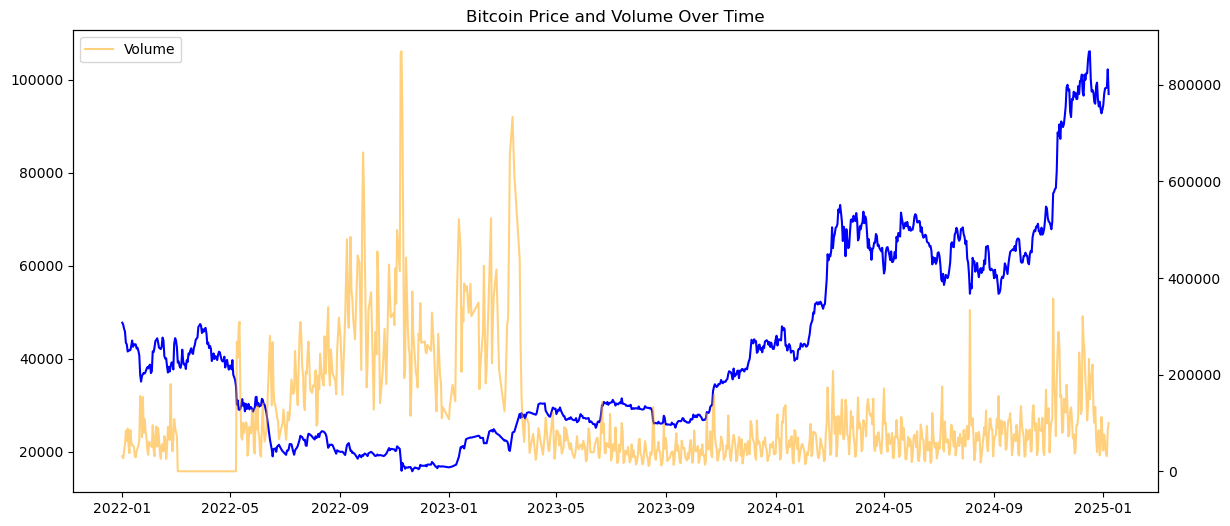

In [7]:
# Step 5: Visualizations

# 1. Price and Volume Over Time
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['price'], label='Price', color='blue')
plt.twinx()
plt.plot(df['date'], df['volume'], label='Volume', color='orange', alpha=0.5)
plt.title("Bitcoin Price and Volume Over Time")
plt.legend(loc='upper left')
plt.show()


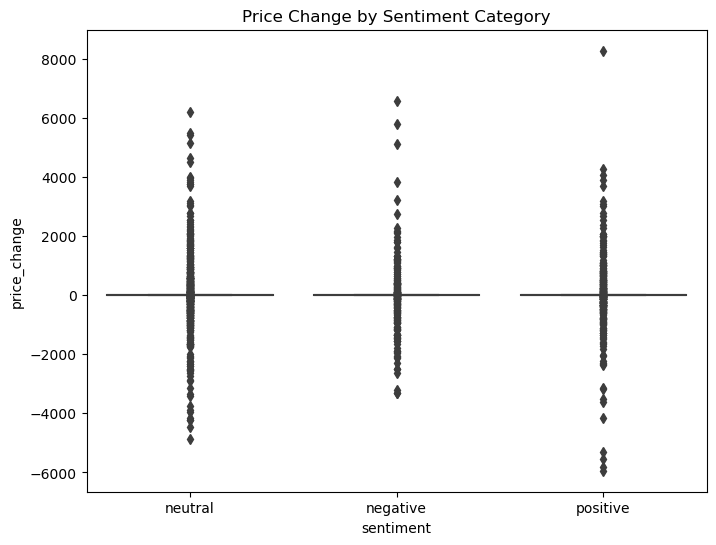

In [8]:
# 2. Price Change by Sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='price_change', data=df)
plt.title("Price Change by Sentiment Category")
plt.show()


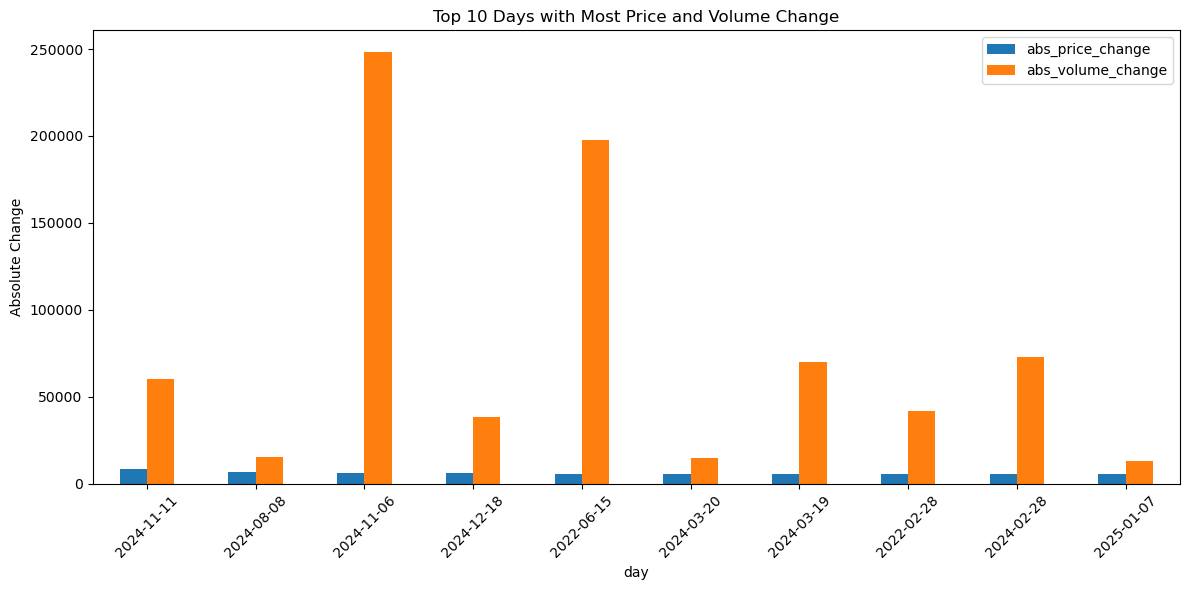

In [9]:
# 3. Top 10 Volatile Days
top_days = df.groupby('day')[['abs_price_change', 'abs_volume_change']].sum()
top_days = top_days.sort_values(by='abs_price_change', ascending=False).head(10)

top_days.plot(kind='bar', figsize=(12, 6))
plt.title("Top 10 Days with Most Price and Volume Change")
plt.ylabel("Absolute Change")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


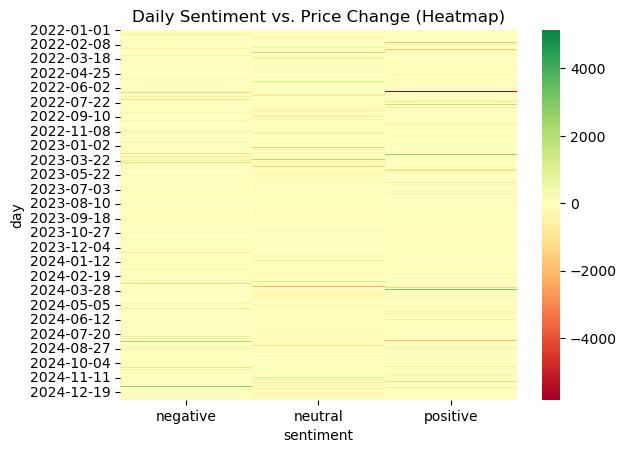

In [10]:
# 4. Sentiment Effect Heatmap
pivot = df.pivot_table(index='day', columns='sentiment', values='price_change', aggfunc='mean')
sns.heatmap(pivot.fillna(0), cmap='RdYlGn', center=0)
plt.title("Daily Sentiment vs. Price Change (Heatmap)")
plt.show()


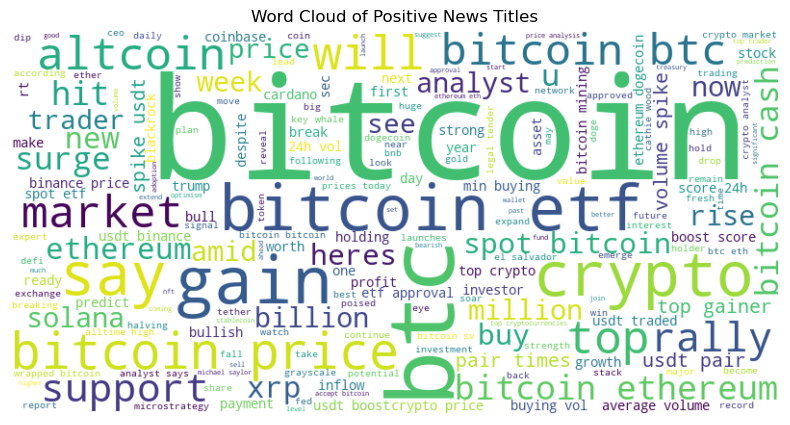

In [11]:
# 5. Word Cloud for Positive News
positive_text = ' '.join(df[df['sentiment'] == 'positive']['news_title'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Positive News Titles")
plt.show()


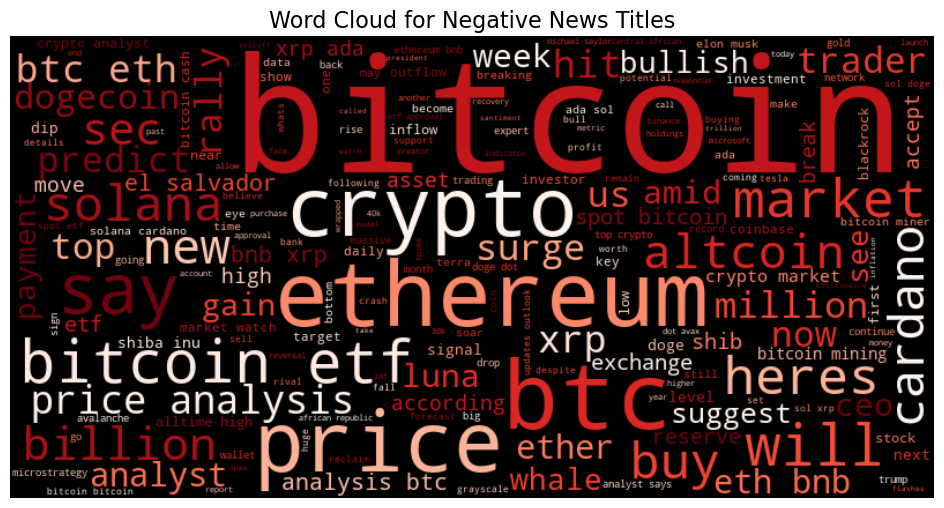

In [12]:
# Filter only negative news titles
negative_titles = df[df['negative'] == 1]['news_title'].dropna()

# Combine all titles into a single string
text = ' '.join(negative_titles)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative News Titles", fontsize=16)
plt.show()


In [13]:
# Step 6: Daily High Price and Low Volume
daily_stats = df.groupby('day').agg({
    'price': 'max',
    'volume': 'min'
}).reset_index()

print(daily_stats.head())


          day  price  volume
0  2022-01-01  47738   31240
1  2022-01-02  47312   27020
2  2022-01-03  46430   41060
3  2022-01-04  45837   55590
4  2022-01-05  43426   83740


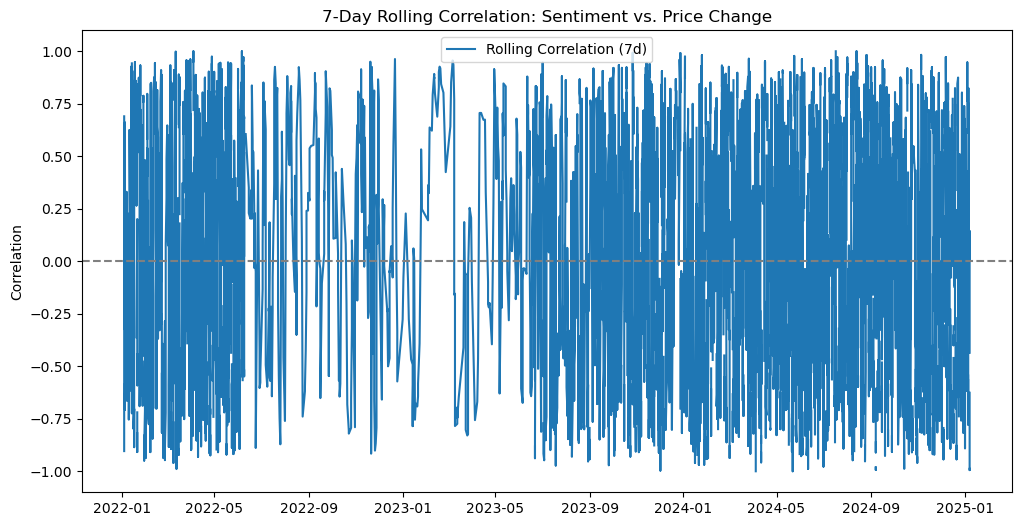

In [14]:
# Rolling correlation (7-day window)
# Visualize how correlation between sentiment and price change evolves over time
df['rolling_sentiment'] = df['sentiment_score'].rolling(window=7).mean()
df['rolling_price_change'] = df['price_change'].rolling(window=7).mean()
df['rolling_corr'] = df['rolling_sentiment'].rolling(7).corr(df['rolling_price_change'])

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['rolling_corr'], label='Rolling Correlation (7d)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("7-Day Rolling Correlation: Sentiment vs. Price Change")
plt.ylabel("Correlation")
plt.legend()
plt.show()


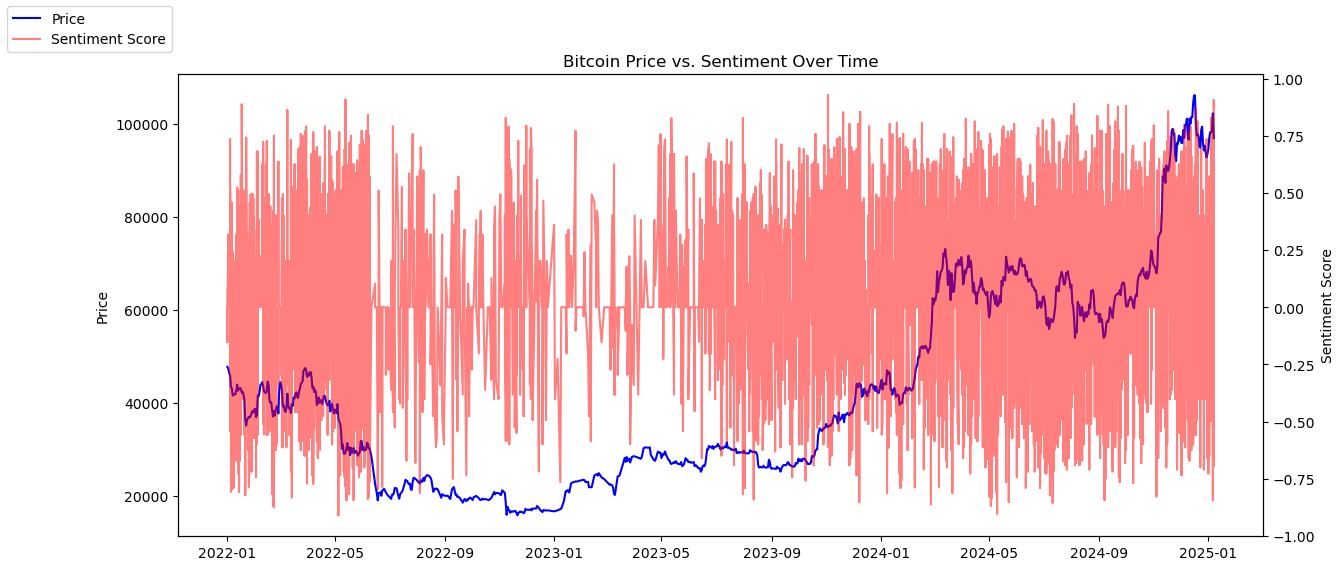

In [15]:
# Overlay sentiment and price trends
# Line Plot of Sentiment and Price Together

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(df['date'], df['price'], color='blue', label='Price')
ax2 = ax1.twinx()
ax2.plot(df['date'], df['sentiment_score'], color='red', alpha=0.5, label='Sentiment Score')

ax1.set_title("Bitcoin Price vs. Sentiment Over Time")
ax1.set_ylabel("Price")
ax2.set_ylabel("Sentiment Score")
fig.legend(loc="upper left")
plt.show()


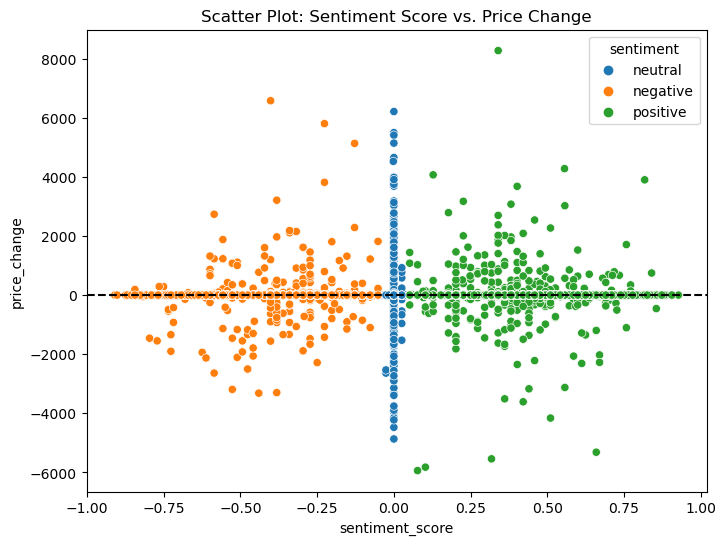

In [16]:
#Scatter Plot: Sentiment Score vs. Price Change
#Reveal linear or nonlinear relationships
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='sentiment_score', y='price_change', hue='sentiment')
plt.title("Scatter Plot: Sentiment Score vs. Price Change")
plt.axhline(0, color='black', linestyle='--')
plt.show()


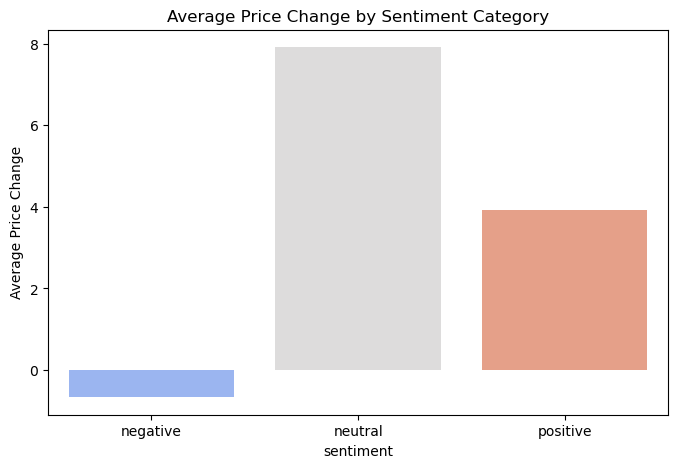

In [17]:
# Bar Plot: Average Price Change by Sentiment Category
# Compare average price movement
sentiment_avg = df.groupby('sentiment')['price_change'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_avg, x='sentiment', y='price_change', palette='coolwarm')
plt.title("Average Price Change by Sentiment Category")
plt.ylabel("Average Price Change")
plt.show()



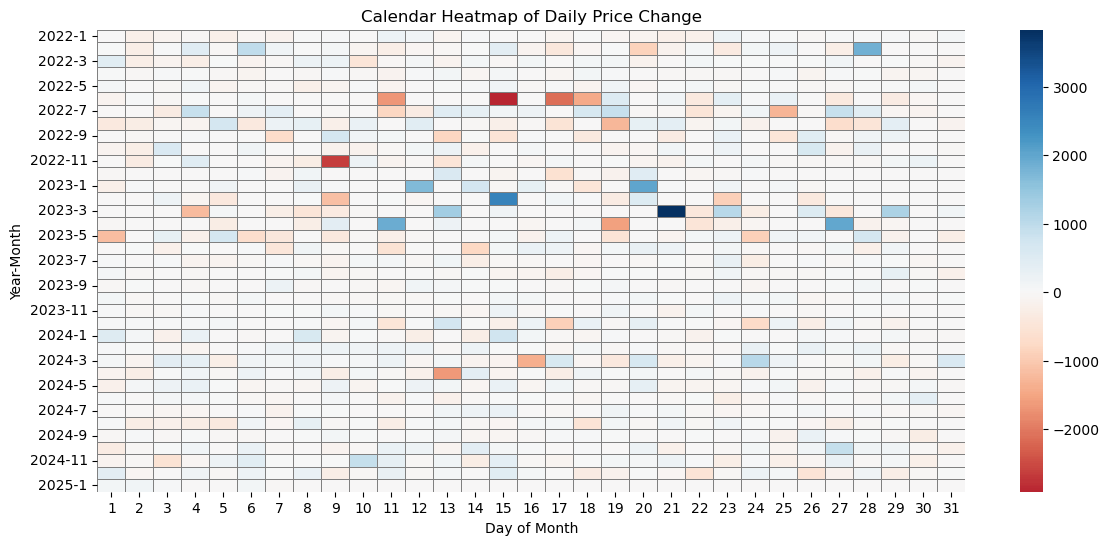

In [18]:
# Calendar Heatmap of Daily Price Change
#  a day-by-day heatmap to spot patterns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day

calendar_data = df.groupby(['year', 'month', 'day_of_month'])['price_change'].mean().unstack(level=2)

plt.figure(figsize=(14, 6))
sns.heatmap(calendar_data.fillna(0), cmap='RdBu', center=0, linewidths=0.5, linecolor='gray')
plt.title("Calendar Heatmap of Daily Price Change")
plt.ylabel("Year-Month")
plt.xlabel("Day of Month")
plt.show()


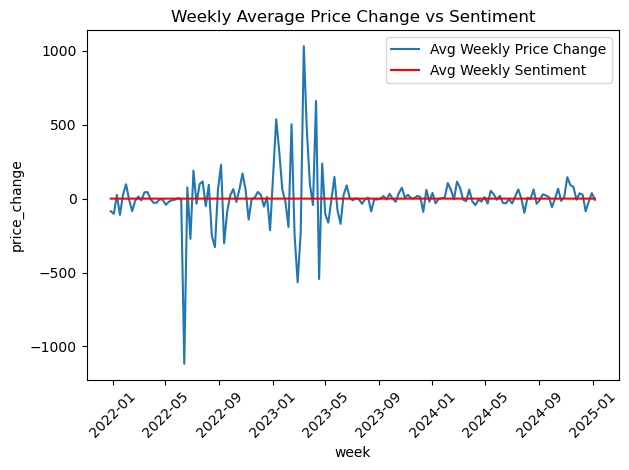

In [19]:
# Weekly Aggregation (More Stable Trends)

df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_summary = df.groupby('week').agg({
    'price_change': 'mean',
    'volume_change': 'mean',
    'sentiment_score': 'mean'
}).reset_index()

sns.lineplot(data=weekly_summary, x='week', y='price_change', label='Avg Weekly Price Change')
sns.lineplot(data=weekly_summary, x='week', y='sentiment_score', label='Avg Weekly Sentiment', color='red')
plt.title("Weekly Average Price Change vs Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
